# Regression and Gradient Descent

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
from pandas import DataFrame,Series
import matplotlib
import sklearn
import time

%matplotlib inline  
import matplotlib.pyplot as plt
from matplotlib import pyplot, pylab
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

from __future__ import division

In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

In [3]:
# reset data as pandas DataFrame
boston_df = DataFrame(bdata.data)

# label columns
boston_df.columns = bdata.feature_names

# Set price column for target
boston_df['MEDV'] = bdata.target

#show
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


---

## Part 1: Getting oriented

Use different learning rates

### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

In [4]:
#first model with RM only
model_1 = smf.ols(formula='MEDV ~ RM', data = boston_df).fit()
#printng
model_1.params

Intercept   -34.670621
RM            9.102109
dtype: float64

In [5]:
#creating new variable
boston_df["RM2"] = boston_df["RM"]**2

#fitting model
model_2 = smf.ols(formula='MEDV ~ RM + RM2', data = boston_df).fit()

#printing
model_2.params

Intercept    66.058847
RM          -22.643262
RM2           2.470124
dtype: float64

* We observe the following -
    * In case of (a), an increase of 1 room increases house price by $9.1K
    * In case of (b), an increase of 1 room will also increase the house price & there is evidence of non linear relationship between price and number of rooms.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 250-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 250 slope coefficients using a histogram with 25 bins, then draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

In [6]:
#defining features and output
X = boston_df["RM"]
y = boston_df["MEDV"]

In [7]:
#defining folds
from sklearn.cross_validation import KFold
kf = KFold(506, n_folds=250)

#creating test and train sets
X_train = []
y_train = []
X_test = []
y_test = []

for train_index, test_index in kf:
    X_train.append(X[train_index])
    y_train.append(y[train_index])
    X_test.append(X[test_index])
    y_test.append(y[test_index])
    
#reshaping, as Linearregression requires matrix form
for i in range(250):
    if i < 6:
        X_train[i] = X_train[i].reshape(503,1)
        y_train[i] = y_train[i].reshape(503,1)
        X_test[i] = X_test[i].reshape(3,1)
        y_test[i] = y_test[i].reshape(3,1)
    else:
        X_train[i] = X_train[i].reshape(504,1)
        y_train[i] = y_train[i].reshape(504,1)
        X_test[i] = X_test[i].reshape(2,1)
        y_test[i] = y_test[i].reshape(2,1)    

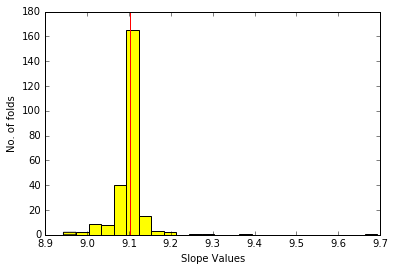

In [8]:
#storing regression results
linear_regression = []
for i in range(250):
    linreg = LinearRegression()
    linear_regression.append(linreg.fit(X_train[i], y_train[i]))   
    
#storing slopes    
slopes = []
for i in range(250):
    slopes.append(linear_regression[i].coef_[0][0])
    
#plotting slope distribution    
plt.hist(slopes, bins = 25, color="yellow")
plt.axvline(x = model_1.params[1],color = "red")
pylab.xlabel("Slope Values")
pylab.ylabel("No. of folds")

* We observe that -
    * After carrying out KFolds and the fitting regression on each fold, most of the coefficient values are around the actual value obtained in the first question.
    * The longest bar on the histogram and the coefficient value from question are overlapping.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

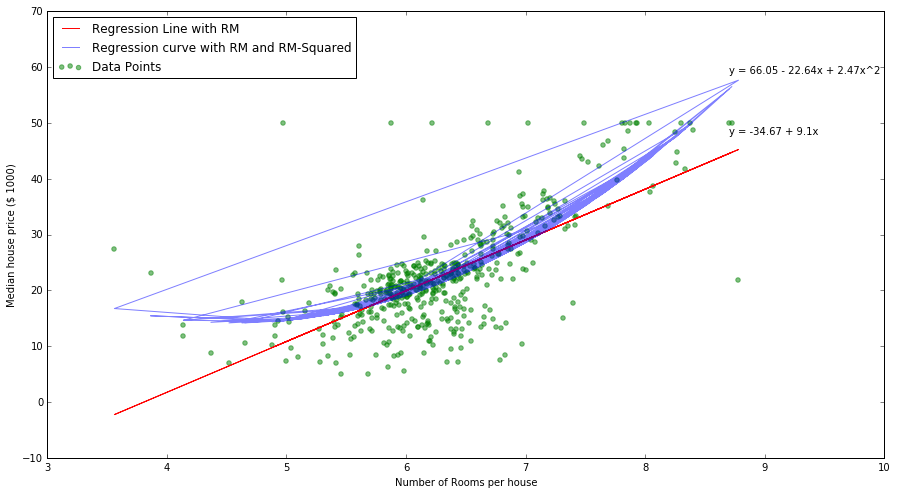

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
#ax.grid(True)
ax.text(8.7, 48, "y = -34.67 + 9.1x")
ax.text(8.7, 59, "y = 66.05 - 22.64x + 2.47x^2")
ax.scatter(boston_df["RM"], boston_df["MEDV"], alpha=0.5, color='green', label ="Data Points")
ax.plot(boston_df["RM"], model_1.params[0] + (model_1.params[1]*boston_df["RM"]), alpha=5, 
        color='red', label = "Regression Line with RM")
ax.plot(boston_df["RM"], 
           model_2.params[0] + (model_2.params[1]*boston_df["RM"]) + (model_2.params[2]*((boston_df["RM"])**2)), 
           alpha=0.5,  color='blue', label = "Regression curve with RM and RM-Squared")
pylab.ylabel("Median house price ($ 1000)")
pylab.xlabel("Number of Rooms per house")
pylab.legend(loc="upper left")

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. *

In [10]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
"""
def bivariate_ols(x, y, R=0.01, MaxIterations=1000):
    # initialize the parameters
    start_time = time.time()
    con = False
    iteration = 0
    n = len(x)
    
    #initial alpha & beta
    a0 = 10
    b0 = 8
    
    sum_j = 0
    for i in range(n):
        sum_j += (a0 + b0*x[i] - y[i])**2
        
    j = sum_j

    while not con:

        sum_grad_a0 = 0
        for i in range(n):
            sum_grad_a0 += (a0 + b0*x[i] - y[i])
            
        sum_grad_b0 = 0
        for i in range(n):
            sum_grad_b0 += (a0 + b0*x[i] - y[i])*x[i]
            
        
        #updating alpha and beta by using learning rate
        
        temp_a0 = a0 - R*sum_grad_a0*(1/n)
        temp_b0 = b0 - R*sum_grad_b0*(1/n)
        
        a0 = temp_a0
        b0 = temp_b0
        
        e = 0
        for i in range(n):
            e += (a0 + b0*x[i] - y[i])**2
            
        
        if(abs(j-e) <= 0.001):
            print " converged after %s iterations." %iteration
            con = True
            
        #update error and iterations
        j = e
        iteration += 1
        
        if iteration == MaxIterations:
            print "Max Iterations reached"
            con = True  
    
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return a0, b0

In [11]:
print "\n For R = 0.001 \n"
print bivariate_ols(boston_df["RM"], boston_df["MEDV"],0.001,1000)
print "\n For R = 0.01 \n"
print bivariate_ols(boston_df["RM"], boston_df["MEDV"],0.01,1000)
print "\n For R = 0.1 \n"
print bivariate_ols(boston_df["RM"], boston_df["MEDV"],0.1,1000)


 For R = 0.001 

Max Iterations reached
Time taken: 20.99 seconds
(8.5687047856375269, 2.3046677929680524)

 For R = 0.01 

Max Iterations reached
Time taken: 22.29 seconds
(4.1336658209751063, 3.0018784024731073)

 For R = 0.1 

Max Iterations reached
Time taken: 21.41 seconds
(nan, nan)


* The values of cefficients, run time for different values of R are stated above.

In [12]:
#bivariate_ols(boston_df["RM"], boston_df["MEDV"],0.01,50000)

* The bivariate function converges after 33110 iterations and gives us the correct slope and intercept values. These values are very close to the actual values.

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [13]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [14]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R, MaxIterations):
    start_time=time.time()
    x=xvalue_matrix
    m=len(yvalues) #calculating length
    epsilon=0.0001
    n=len(x.T) #taking length of transposed matrix
    
    #array of coefficients
    theta=np.array([10]*n)
    theta=theta.reshape(-1,1)
    
    #transposing input
    xTrans = x.transpose()
    
    #reshaping output values
    y=yvalues.reshape(-1,1)
    
    #calculating hypothesis
    yhat = np.dot(x, theta)
    
    #calculating loss
    e=yhat-y
    
    #calculating cost
    J = np.sum(e**2)
    converged=False

    iterations=0
    while not converged: 

        #average value of gradient
        gradient = np.dot(xTrans, e) / m
        
        #updating theta
        theta = theta - R * gradient
        
        #updating hypothesis, loss and cost based on updated coefficients
        yhat = np.dot(x, theta)
        e = yhat - y
        cost = np.sum(e ** 2)

        if abs(J-cost)<=epsilon:
            print 'Converged after %s iterations: '%iterations
            converged = True

        else:
            J=cost
        if iterations==MaxIterations:
            print "Max iterations reached"
            converged=True
        iterations=iterations+1
        
    
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return theta

In [15]:
#creating input matrix for x_matrix
x_matrix = np.ones((506, 3, ))
x_matrix[:,1:2] = standardize(boston_df["RM"]).reshape(506,1)
x_matrix[:,2:3] = standardize(boston_df["CRIM"]).reshape(506,1)

print "\n For R = 0.1 \n"
print multivariate_ols(x_matrix, boston_df["MEDV"], 0.1, 10000)
print "\n For R = 0.01 \n"
print multivariate_ols(x_matrix, boston_df["MEDV"], 0.01, 10000)
print "\n For R = 0.001 \n"
print multivariate_ols(x_matrix, boston_df["MEDV"], 0.001, 10000)


 For R = 0.1 

Converged after 113 iterations: 
Time taken: 0.0 seconds
[[ 22.53273017]
 [  5.89519421]
 [ -2.24782868]]

 For R = 0.01 

Converged after 1018 iterations: 
Time taken: 0.02 seconds
[[ 22.53235932]
 [  5.89720009]
 [ -2.24579562]]

 For R = 0.001 

Converged after 8754 iterations: 
Time taken: 0.15 seconds
[[ 22.5308389 ]
 [  5.90314339]
 [ -2.23969647]]


* We observe the following -
    * There is convergence after larger number of iterations if learning rate is small, so it takes more time also.
    * However, the values of coeffs remain almost same in all chosen values of learning rate.
    * Standardized values converge faster.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [16]:
# new matrix - un standardized data
x_matrix = np.ones((506, 3, ))
x_matrix[:,1:2] = (boston_df["RM"]).reshape(506,1)
x_matrix[:,2:3] = (boston_df["CRIM"]).reshape(506,1)

print "\n For R = 0.001 \n"
print multivariate_ols(x_matrix, boston_df["MEDV"], 0.001, 1000000)
print "\n For R = 0.01 \n"
print multivariate_ols(x_matrix, boston_df["MEDV"], 0.01, 1000000)


 For R = 0.001 

Converged after 336660 iterations: 
Time taken: 5.89 seconds
[[-28.42492053]
 [  8.26126066]
 [ -0.26475149]]

 For R = 0.01 

Converged after 43941 iterations: 
Time taken: 0.72 seconds
[[-29.02447588]
 [  8.35444689]
 [ -0.26274883]]


* We observe the following -
    * Unstandardized values take a very long time and large number of iterations to converge.
    * The values of coeffs vary a lot when the learning rate is changed.

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Since the focus is now on prediction rather than the interpretation of the coefficients, it would be wise for you to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

In [17]:
# importing library
from sklearn.cross_validation import train_test_split

#creating input
x_matrix = np.ones((506, 3, ))
x_matrix[:,1:2] = standardize(boston_df["RM"]).reshape(506,1)
x_matrix[:,2:3] = standardize(boston_df["CRIM"]).reshape(506,1)
y = boston_df["MEDV"]

#creating test and train
X_train, X_test, y_train, y_test = train_test_split(x_matrix, y, test_size=0.34, random_state = 5)

In [18]:
model_3 = multivariate_ols(X_train, y_train, 0.01, 10000)
model_3

Converged after 998 iterations: 
Time taken: 0.02 seconds


array([[ 22.45804901],
       [  6.02338556],
       [ -2.70739531]])

* The results obtained after splitting the data and fitting regression on training data is almost the same as 2.3.

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above and compare the actual to the predicted values for just the test instances. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [19]:
#defining function for RMSE
def compute_rmse(prediction,yvalues):
    if len(np.array(prediction))==len(np.array(yvalues)):
        rmse = np.sqrt(np.mean((np.array(prediction)-np.array(yvalues))**2))
    else:
        print("array length not equal")
        return -1
    return rmse   

In [20]:
#prediction values using model coeffs
y_pred = []
for i in range(len(X_test)):
    y_pred.append((model_3[0] + model_3[1]*X_test[i][1] + model_3[2]*X_test[i][2])[0])
    
#storing actual values in list
y_actual = []
for i in y_test.index:
    y_actual.append(y_test[i])

In [21]:
compute_rmse(y_pred, y_actual)

7.1082223440812164

* The RMSE is around 7.1. The RMSE for nearest neighbours in the last problem set was ranging between 6 to 9 depending on the value of the L. So, we can say that RMSE values are in the same range.

### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $400,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [22]:
# Your code here
from math import exp 
def logistic_ols(x, y, R=0.01, MaxIterations=1000):
    # initialize the parameters
    start_time = time.time()
    con = False
    iteration = 0
    n = len(x)
    
    #initial alpha & beta
    a0 = 10
    b = [8,5]
    
    
    sum_j = 0
    for i in range(n):
        sum_j += (y[i] - 1/(1+exp(-(a0 + b[0]*x[i] + b[1]*x[i]))))*x[i]
        
    j = sum_j

    while not con:

        sum_grad_a0 = 0
        for i in range(n):
            sum_grad_a0 += (y[i] - 1/(1+exp(-(a0 + b[0]*x[i] + b[1]*x[i]))))
            
        sum_grad_b0 = 0
        for i in range(n):
            sum_grad_b0 += (y[i] - 1/(1+exp(-(a0 + b[0]*x[i] + b[1]*x[i]))))*x[i]
            
        sum_grad_c0 = 0
        for i in range(n):
            sum_grad_c0 += (y[i] - 1/(1+exp(-(a0 + b[0]*x[i] + b[1]*x[i]))))*x[i]
            
        
        #updating alpha and beta by using learning rate
        
        temp_a0 = a0 - R*sum_grad_a0*(1/n)
        temp_b0 = b[0] - R*sum_grad_b0*(1/n)
        temp_b1 = b[1] - R*sum_grad_c0*(1/n)
        
        a0 = temp_a0
        b[0] = temp_b0
        b[1] = temp_b1
        
        e = 0
        for i in range(n):
            e += (y[i] - 1/(1+exp(-(a0 + b[0]*x[i] + b[1]*x[i]))))*x[i]
            
        
        if(abs(j-e) <= 0.001):
            print " converged after %s iterations." %iteration
            con = True
            
        #update error and iterations
        j = e
        iteration += 1
        
        if iteration == MaxIterations:
            print "Max Iterations reached"
            con = True  
    
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return a0, b

In [23]:
logistic_ols(standardize(boston_df["RM"]), boston_df["MEDV"], 0.01, 1000)

 converged after 101 iterations.
Time taken: 4.98 seconds


(-12.589932462067246, [1.7097906835197385, -1.2902093164802619])

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have *K+K^2/2* features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [24]:
# reset data as pandas DataFrame
new_boston_df = DataFrame(bdata.data)

# label columns
new_boston_df.columns = bdata.feature_names

# Set price column for target
#new_boston_df['MEDV'] = bdata.target

#show
#new_boston_df.head()

#creating a list for new features
features = []
for i in new_boston_df.columns:
    features.append(i)
    
#creating new features    
for i in range(13):
    f1 = features[i]
    new_boston_df[f1+"*"+f1]=new_boston_df[f1]*new_boston_df[f1]
    j = i+1
    for j in range(j,13):
        f2 = features[j]
        new_boston_df[f1+"*"+f2]=new_boston_df[f1]*new_boston_df[f2]
        
        
# Set price column for target
new_boston_df['MEDV'] = bdata.target

### 4.2 Let's overfit!
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those *K+K/2* features as you can.  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [25]:
#creating new input with 15 features
x_matrix = np.ones((506, 16, ))

x_matrix[:,1:2] = standardize(new_boston_df["RM"]).reshape(506,1)
x_matrix[:,2:3] = standardize(new_boston_df["CRIM"]).reshape(506,1)
x_matrix[:,3:4] = standardize(new_boston_df["DIS"]).reshape(506,1)
x_matrix[:,4:5] = standardize(new_boston_df["RAD"]).reshape(506,1)
x_matrix[:,5:6] = standardize(new_boston_df["TAX"]).reshape(506,1)
x_matrix[:,6:7] = standardize(new_boston_df["PTRATIO"]).reshape(506,1)
x_matrix[:,7:8] = standardize(new_boston_df["AGE"]).reshape(506,1)
x_matrix[:,8:9] = standardize(new_boston_df["LSTAT"]).reshape(506,1)
x_matrix[:,9:10] = standardize(new_boston_df["RM*LSTAT"]).reshape(506,1)
x_matrix[:,10:11] = standardize(new_boston_df["CRIM*RM"]).reshape(506,1)
x_matrix[:,11:12] = standardize(new_boston_df["CRIM*LSTAT"]).reshape(506,1)
x_matrix[:,12:13] = standardize(new_boston_df["CRIM*PTRATIO"]).reshape(506,1)
x_matrix[:,13:14] = standardize(new_boston_df["DIS*TAX"]).reshape(506,1)
x_matrix[:,14:15] = standardize(new_boston_df["AGE*DIS"]).reshape(506,1)
x_matrix[:,15:16] = standardize(new_boston_df["ZN*LSTAT"]).reshape(506,1)

y = new_boston_df["MEDV"]

#splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(x_matrix, y, test_size=0.34, random_state = 5)

In [26]:
# fitting the model
model_4 = multivariate_ols(X_train, y_train, 0.01, 100000)
#printing the coeffs
model_4

Converged after 56266 iterations: 
Time taken: 1.47 seconds


array([[ 22.44432146],
       [  6.99763349],
       [  4.49147135],
       [ -1.70812017],
       [  1.53113237],
       [ -1.9664907 ],
       [ -1.28731044],
       [ -1.04101455],
       [ 15.80111177],
       [-16.90686489],
       [ -6.26472801],
       [ -5.24880117],
       [  5.49683818],
       [ -0.30529042],
       [  0.2765893 ],
       [  0.42280051]])

In [27]:
#storing the predicted values for the train set into a list
y_trainset = []
for i in range(len(X_train)):
    y_trainset.append((model_4[0] 
                       + model_4[1]*X_train[i][1] 
                       + model_4[2]*X_train[i][2]
                       + model_4[3]*X_train[i][3]
                       + model_4[4]*X_train[i][4]
                       + model_4[5]*X_train[i][5]
                       + model_4[6]*X_train[i][6]
                       + model_4[7]*X_train[i][7]
                       + model_4[8]*X_train[i][8]
                       + model_4[9]*X_train[i][9]
                       + model_4[10]*X_train[i][10]
                       + model_4[11]*X_train[i][11]
                       + model_4[12]*X_train[i][12]
                       + model_4[13]*X_train[i][13]
                       + model_4[14]*X_train[i][14]
                       + model_4[15]*X_train[i][15])[0])

#storing the predicted values for the test set into a list    
y_testset = []
for i in range(len(X_test)):
    y_testset.append((model_4[0] 
                       + model_4[1]*X_test[i][1] 
                       + model_4[2]*X_test[i][2]
                       + model_4[3]*X_test[i][3]
                       + model_4[4]*X_test[i][4]
                       + model_4[5]*X_test[i][5]
                       + model_4[6]*X_test[i][6]
                       + model_4[7]*X_test[i][7]
                       + model_4[8]*X_test[i][8]
                       + model_4[9]*X_test[i][9]
                       + model_4[10]*X_test[i][10]
                       + model_4[11]*X_test[i][11]
                       + model_4[12]*X_test[i][12]
                       + model_4[13]*X_test[i][13]
                       + model_4[14]*X_test[i][14]
                       + model_4[15]*X_test[i][15])[0])

In [28]:
compute_rmse(y_trainset, y_train)

3.7636932206980815

In [29]:
compute_rmse(y_testset, y_test)

4.9985235118860514

* We observe that -
    * Upon fitting the model on the training set the RMSE = 3.73
    * Upon fitting the model on the test set the RMSE = 4.99

* This is expected as our model will always perform better on training data and perform poorly on unseen test data.
* The values of RMSE are lower than that of section 3.2 or nearest neighbours.

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 3.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [30]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def ridge_multivariate_ols(xvalue_matrix, yvalues, R, L, MaxIterations):
    start_time=time.time()
    x=xvalue_matrix
    m=len(yvalues)
    epsilon=0.0001
    n=len(x.T)
    
    #array of coefficients
    theta=np.array([10]*n)
    theta=theta.reshape(-1,1)
    
    xTrans = x.transpose()
    y=yvalues.reshape(-1,1)
    
    #calculating hypothesis
    yhat = np.dot(x, theta)
    
    #calculating loss
    e=yhat-y
    
    #calculating cost
    J = np.sum(e**2)
    converged=False

    iterations=0
    while not converged: 

        #average value of gradient
        gradient = np.dot(xTrans, e) / m
        
        #updating theta
        theta = theta - R * (gradient + (L/m)*theta)
        
        #updating hypothesis, loss and cost based on updated coefficients
        yhat = np.dot(x, theta)
        e = yhat - y
        cost = np.sum(e ** 2)

        if abs(J-cost)<=epsilon:
            print 'Converged after %s iterations: '%iterations
            converged = True

        else:
            J=cost
        if iterations==MaxIterations:
            print "Max iterations reached"
            converged=True
        iterations=iterations+1
        
    
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return theta

In [31]:
#creating new input with 6 features
x_matrix = np.ones((506, 7, ))

x_matrix[:,1:2] = standardize(new_boston_df["RM"]).reshape(506,1)
x_matrix[:,2:3] = standardize(new_boston_df["CRIM"]).reshape(506,1)
x_matrix[:,3:4] = standardize(new_boston_df["DIS"]).reshape(506,1)
x_matrix[:,4:5] = standardize(new_boston_df["RAD"]).reshape(506,1)
x_matrix[:,5:6] = standardize(new_boston_df["TAX"]).reshape(506,1)
x_matrix[:,6:7] = standardize(new_boston_df["PTRATIO"]).reshape(506,1)


y = new_boston_df["MEDV"]

#splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(x_matrix, y, test_size=0.34, random_state = 5)

In [32]:
#L = [1,5,10,20,50,100,250,500,1000,2000,5000,10000]
L = [0.001,0.005,0.1,0.5,0.7,1,3,5,7,10,13,15,20]

In [33]:
for l in L:
    model_4 = ridge_multivariate_ols(X_train, y_train, 0.01, l, 10000)

    y_pred = []
    for i in range(len(X_test)):
        y_pred.append((model_4[0] 
                       + model_4[1]*X_test[i][1] 
                       + model_4[2]*X_test[i][2]
                       + model_4[3]*X_test[i][3]
                       + model_4[4]*X_test[i][4]
                       + model_4[5]*X_test[i][5]
                       + model_4[6]*X_test[i][6])[0])
    
    y_actual = []
    for i in y_test.index:
        y_actual.append(y_test[i])
    
    print "RMSE for L = %s"%l 
    print compute_rmse(y_pred, y_actual)
    print "\n"

Converged after 6550 iterations: 
Time taken: 0.22 seconds
RMSE for L = 0.001
6.7464079136


Converged after 6556 iterations: 
Time taken: 0.12 seconds
RMSE for L = 0.005
6.74642028886


Converged after 6699 iterations: 
Time taken: 0.13 seconds
RMSE for L = 0.1
6.74671770167


Converged after 7236 iterations: 
Time taken: 0.18 seconds
RMSE for L = 0.5
6.74804689906


Converged after 7450 iterations: 
Time taken: 0.24 seconds
RMSE for L = 0.7
6.74875941253


Converged after 7705 iterations: 
Time taken: 0.15 seconds
RMSE for L = 1
6.74988870516


Converged after 8310 iterations: 
Time taken: 0.3 seconds
RMSE for L = 3
6.75919823152


Converged after 8251 iterations: 
Time taken: 0.17 seconds
RMSE for L = 5
6.77133736174


Converged after 8017 iterations: 
Time taken: 0.22 seconds
RMSE for L = 7
6.78600847624


Converged after 7579 iterations: 
Time taken: 0.21 seconds
RMSE for L = 10
6.81230619051


Converged after 7134 iterations: 
Time taken: 0.16 seconds
RMSE for L = 13
6.8432962981

* The RMSE for different values of lambda are reported above. We observe the following -
    * The RMSE values remains similar to the value of RMSE from 2.3 for lambda values uptil 20.
    * The RMSE values tend to increase with increasing value of lambda.
    * These RMSE values are higher when comared to section 4.2 and are similar to the RMSE from 3.2 and nearest neighbours.

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

In [34]:
#creating new matrix with 2 features
x_matrix = np.ones((506, 3, ))
x_matrix[:,1:2] = standardize(boston_df["RM"]).reshape(506,1)
x_matrix[:,2:3] = standardize(boston_df["CRIM"]).reshape(506,1)
y = boston_df["MEDV"]

In [35]:
# creating folds
kf=KFold(len(boston_df), n_folds=10, random_state = 5)

#creating coef matrix
coef = np.zeros([10,3,1])

#creating vectors for test and train
train_rmse = np.zeros(10)
test_rmse = np.zeros(10)

#L = [0.001,0.005,0.1,0.2,0.5,0.7,0.85,1,2,4,5,8,10,11,13,15,20,50,100,250,500]
L = [0.001,0.005,0.1,0.5,0.7,1,3,5,7,10,13,15,20]


mean_rmse_train,mean_rmse_test = np.zeros(len(L)), np.zeros(len(L))

a,b =0,0

for l in L:
    for train_index, test_index in kf:
        coef[a] = ridge_multivariate_ols(x_matrix[train_index], y[train_index], 0.01, 1000,l)
        y_train = y[train_index].reshape(-1,1)
        y_test = y[test_index].reshape(-1,1)
        train_rmse[a] = np.sqrt(np.sum((np.dot(x_matrix[train_index],coef[a])-y_train)**2)/len(y_train))
        test_rmse[a] = np.sqrt(np.sum((np.dot(x_matrix[test_index],coef[a])-y_test)**2)/len(y_test))
        a+=1
    
    a=0
    mean_rmse_train[b]=np.mean(train_rmse)
    mean_rmse_test[b]=np.mean(test_rmse)
    b+=1

print mean_rmse_train
print mean_rmse_test

Converged after 492 iterations: 
Time taken: 0.03 seconds
Converged after 519 iterations: 
Time taken: 0.02 seconds
Converged after 474 iterations: 
Time taken: 0.01 seconds
Converged after 542 iterations: 
Time taken: 0.02 seconds
Converged after 541 iterations: 
Time taken: 0.01 seconds
Converged after 551 iterations: 
Time taken: 0.01 seconds
Converged after 506 iterations: 
Time taken: 0.01 seconds
Converged after 578 iterations: 
Time taken: 0.02 seconds
Converged after 572 iterations: 
Time taken: 0.02 seconds
Converged after 520 iterations: 
Time taken: 0.01 seconds
Converged after 492 iterations: 
Time taken: 0.02 seconds
Converged after 519 iterations: 
Time taken: 0.02 seconds
Converged after 474 iterations: 
Time taken: 0.01 seconds
Converged after 542 iterations: 
Time taken: 0.03 seconds
Converged after 541 iterations: 
Time taken: 0.03 seconds
Converged after 551 iterations: 
Time taken: 0.02 seconds
Converged after 506 iterations: 
Time taken: 0.03 seconds
Converged afte

* Upon examining, The value of optimum value of L comes out to be 20, as it reports the least error.

### (Showoff) Extra Credit 3: Lambda and coefficients

If you're feeling extra-special, create a parameter plot that shows how the different coefficient estimates change as a function of lambda. To make this graph intelligible, only include the *K* original F_s features in this plot

Converged after 6176 iterations: 
Time taken: 0.23 seconds
Converged after 6181 iterations: 
Time taken: 0.2 seconds
Converged after 6320 iterations: 
Time taken: 0.25 seconds
Converged after 6849 iterations: 
Time taken: 0.3 seconds
Converged after 7071 iterations: 
Time taken: 0.31 seconds
Converged after 7348 iterations: 
Time taken: 0.28 seconds
Converged after 8177 iterations: 
Time taken: 0.32 seconds
Converged after 8304 iterations: 
Time taken: 0.31 seconds
Converged after 8211 iterations: 
Time taken: 0.21 seconds
Converged after 7921 iterations: 
Time taken: 0.32 seconds
Converged after 7571 iterations: 
Time taken: 0.34 seconds
Converged after 7332 iterations: 
Time taken: 0.29 seconds
Converged after 6755 iterations: 
Time taken: 0.19 seconds
Converged after 4530 iterations: 
Time taken: 0.12 seconds
Converged after 3233 iterations: 
Time taken: 0.09 seconds
Converged after 1919 iterations: 
Time taken: 0.05 seconds
Converged after 1167 iterations: 
Time taken: 0.04 seconds

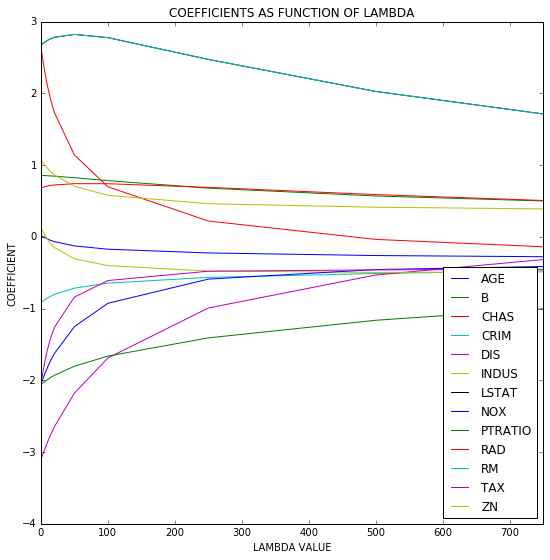

In [36]:
# taking all the features of the original data set
x_matrix = np.ones((506, 14, ))
x_matrix[:,1:2] = standardize(boston_df["RM"]).reshape(506,1)
x_matrix[:,2:3] = standardize(boston_df["CRIM"]).reshape(506,1)
x_matrix[:,3:4] = standardize(boston_df["ZN"]).reshape(506,1)
x_matrix[:,4:5] = standardize(boston_df["INDUS"]).reshape(506,1)
x_matrix[:,5:6] = standardize(boston_df["CHAS"]).reshape(506,1)
x_matrix[:,6:7] = standardize(boston_df["NOX"]).reshape(506,1)
x_matrix[:,7:8] = standardize(boston_df["AGE"]).reshape(506,1)
x_matrix[:,8:9] = standardize(boston_df["DIS"]).reshape(506,1)
x_matrix[:,9:10] = standardize(boston_df["RAD"]).reshape(506,1)
x_matrix[:,10:11] = standardize(boston_df["TAX"]).reshape(506,1)
x_matrix[:,11:12] = standardize(boston_df["PTRATIO"]).reshape(506,1)
x_matrix[:,12:13] = standardize(boston_df["B"]).reshape(506,1)
x_matrix[:,13:14] = standardize(boston_df["LSTAT"]).reshape(506,1)
y = boston_df["MEDV"]

#taking high values of L in order to see behavior
L = [0.001,0.005,0.1,0.5,0.7,1,3,5,7,10,13,15,20,50,100,250,500,750]

#list to store models
ridge_models = []
for l in L:
    ridge_models.append(ridge_multivariate_ols(x_matrix, y, 0.01, l, 10000))

#separate lists for features to store coeffs    
RM=[]
CRIM =[]
ZN = []
INDUS =[]
CHAS = []
NOX =[]
AGE = []
DIS = []
RAD = []
TAX = []
PTRATIO = []
B = []
LSTAT = []
for i in range(len(L)):
    RM.append(ridge_models[i][1][0])
    CRIM.append(ridge_models[i][2][0])
    ZN.append(ridge_models[i][3][0])
    INDUS.append(ridge_models[i][4][0])
    CHAS.append(ridge_models[i][5][0])
    NOX.append(ridge_models[i][6][0])
    AGE.append(ridge_models[i][7][0])
    DIS.append(ridge_models[i][8][0])
    RAD.append(ridge_models[i][9][0])
    TAX.append(ridge_models[i][10][0])
    PTRATIO.append(ridge_models[i][11][0])
    B.append(ridge_models[i][12][0])
    LSTAT.append(ridge_models[i][13][0])
    
#making a data frame    
coef_df = pd.DataFrame({"L":L, 'RM':RM, 'CRIM':CRIM, 'ZN':ZN, 'INDUS':INDUS,
                       "CHAS":CHAS, 'NOX':NOX, 'AGE':AGE, 'DIS':DIS, 'RAD':RAD,
                       "TAX":TAX, 'LSTAT':RM, 'PTRATIO':PTRATIO, 'B':B})
#plot
coef_df.plot(x = "L", y = ["AGE","B","CHAS","CRIM","DIS","INDUS","LSTAT","NOX","PTRATIO","RAD","RM","TAX","ZN"], 
             figsize = (9,9))
pylab.title("COEFFICIENTS AS FUNCTION OF LAMBDA")
pylab.xlabel("LAMBDA VALUE")
pylab.ylabel("COEFFICIENT")

* As the value of lamda increases, the coefficients converge to zero. 
* This is logical as higher lambda values will penalize the coefficients more and more. They will almost become zero.